In [1]:
!pip install koreanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 26.0 MB/s eta 0:00:00


In [2]:
!pip install yellowbrick

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [4]:
rfm = pd.read_csv('rfm.csv',index_col='CustomerID')
rfm.shape

(4338, 9)

In [5]:
rfm_cluster = rfm.iloc[:,:3]

In [6]:
rfm_cluster.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.583679,90.523513,2009.852304
std,100.019339,225.507058,8622.507371
min,1.000000,1.000000,2.900000
25%,18.000000,17.000000,306.452500
50%,51.000000,41.000000,668.495000
75%,142.750000,98.000000,1659.132500
max,374.000000,7676.000000,280206.020000


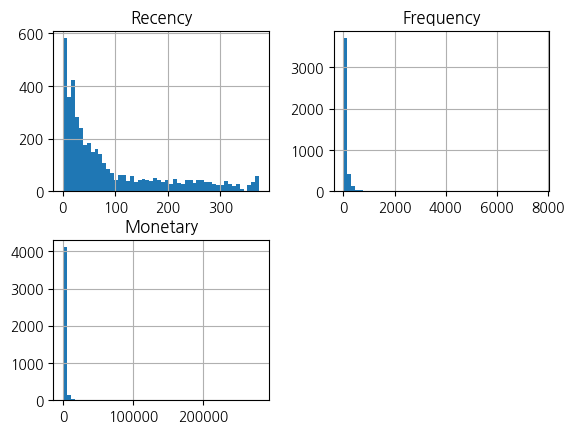

In [7]:
rfm_cluster.hist(bins=50);

In [8]:
# 정규 분포 형태가 아니면 성능이 낮게 나올 수 있다.
# 최대한 정규 분포 형태로 좋은 성능을 유도해보자
# 로그변환 : 머신러닝 모델의 학습성능을 위해 정규분포로 변환

In [9]:
# 로그변환에 단점 : 해석이 어려워진다, 데이터 손실이 발생 할 수 있다, 0또는 음의값은 변환이 불가능 하다

In [10]:
rfm_cluster_log = np.log(rfm_cluster+1)
## rfm_cluster_log = np.log1p(rfm_cluster) 이렇게도 쓸 수 있다.
rfm_cluster_log.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,3.831803,3.728972,6.586102
std,1.339608,1.245411,1.258222
min,0.693147,0.693147,1.360977
25%,2.944439,2.890372,5.728321
50%,3.951244,3.737670,6.506524
75%,4.968071,4.595120,7.414652
max,5.926926,8.945984,12.543284


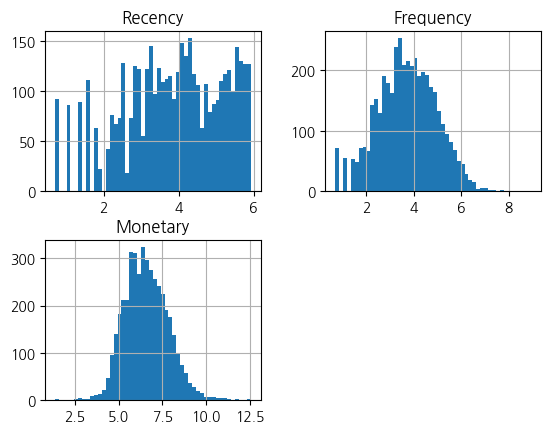

In [11]:
# hist
# 로그 변환의 힘... ㅎㄷㄷ
rfm_cluster_log.hist(bins=50);

**스케일 조정하기**
- standard -> 평균을 빼고 표준편차로 나눠줌
- minmax -> 최솟값을 0 최댓값을 1로 만듬
- robust -> 중간값을 0으로 만듬 IQR 값으로 나눠주는 공식

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(rfm_cluster_log)
X = pd.DataFrame(X,columns=rfm_cluster_log.columns)
X2 = scaler.fit_transform(rfm_cluster_log)
X2 = pd.DataFrame(X,columns=rfm_cluster_log.columns)

In [14]:
# sklearn.preprocessing 의 standaradscaler 로 변환
# z = (x-u)/std
X.describe().round(2)

,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-2.34,-2.44,-4.15
25%,-0.66,-0.67,-0.68
50%,0.09,0.01,-0.06
75%,0.85,0.70,0.66
max,1.56,4.19,4.74


array([[<Axes: title={'center': 'Recency'}>,
        <Axes: title={'center': 'Frequency'}>],
       [<Axes: title={'center': 'Monetary'}>, <Axes: >]], dtype=object)

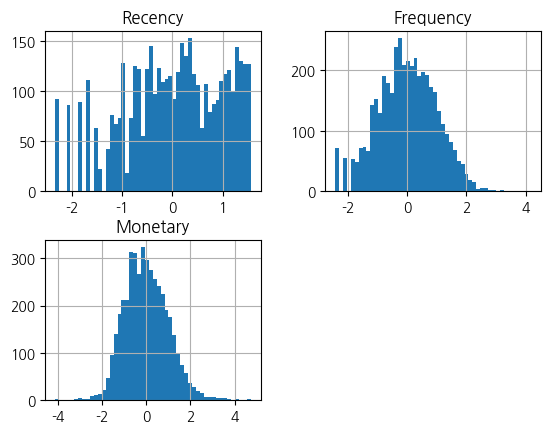

In [15]:
X.hist(bins=50)

K-means


In [16]:
# cluster.Kmeans, metrics.silhouette_score 불러오기
# rfm_norm 값을 학습하고
# elobw 값을 보기위해 inertia_ 값을 리스트로 만듬
# silhouette_score(X,kmeans.labels_) 값도 리스트로 만듭니다.


'''
kmeans(
  n_clusters = 3,
  *,
  init = 'k-means++',
  n_init = 'auto',
  max_iter = 300,
  tol = 0.0001,
  verbose = 0,
  random_state = None,
  copy_x = True,
  alorithm ='lloyd'
)
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=3,n_init='auto',random_state=42)
kmeans.fit(X)
kmeans.cluster_centers_, kmeans.inertia_

(array([[-0.04434947,  0.14435246,  0.08074503],
        [ 0.79654483, -0.97733495, -0.91830586],
        [-1.09752177,  1.18220079,  1.21114612]]),
 5237.310351848511)

In [17]:
inertia=[]
silhouettes = []
range_n_clusters= range(2,21)

for n_cluster in range_n_clusters:
  kmeans = KMeans(n_clusters=n_cluster,n_init='auto',random_state=42)
  kmeans.fit(X)
  inertia.append(kmeans.inertia_)
  silhouettes.append(silhouette_score(X,labels=kmeans.labels_))
  print(n_cluster,end=',')

2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,

<Axes: >

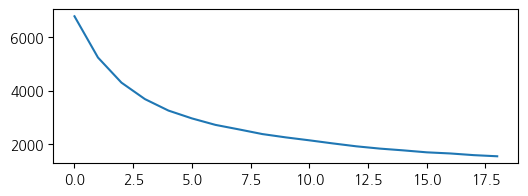

In [18]:
pd.Series(inertia).plot(figsize=(6,2))

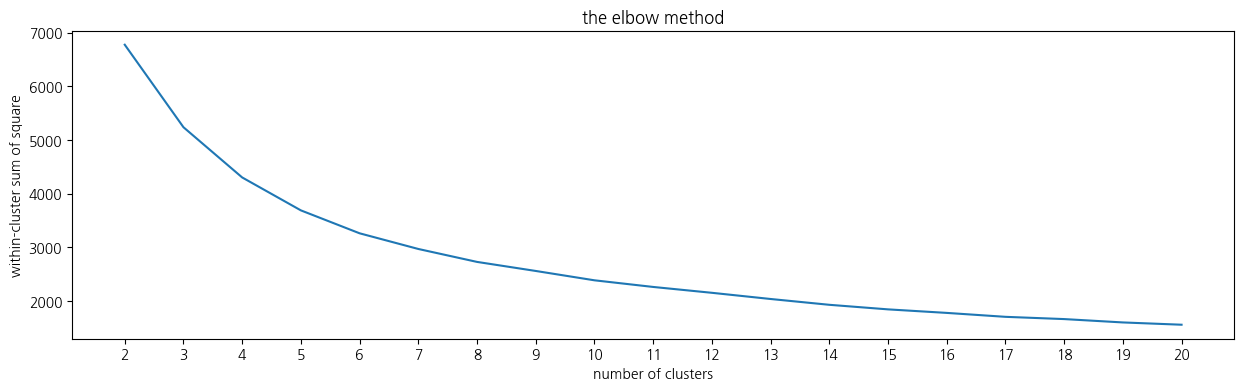

In [19]:
plt.figure(figsize=(15,4))
plt.plot(range_n_clusters,inertia)
plt.title('the elbow method')
plt.xlabel('number of clusters')
plt.ylabel('within-cluster sum of square')
plt.xticks(range_n_clusters)
plt.show()
# 5,6 으로 군집의 수를 결정하면 좋을 거 같다.

**Silhoutte Score**
- 실루엣 계수는 군집화의 성능을 평가하기 위한 지표 중 하나
- 각 데이터 포인트의 실루엣 계수는 해당 데이터 포인트가 얼마나 잘 클러스터링 되었는지 나타낸다.
- 정답 레이블을 모르는 경우 모델 자체를 사용하여 평가 수행
- 실루엣 계수는 각 샘플에 대해 정의되며 두 가지 점수로 구성
  - a : 같은 클러스터 내의 다른 데이터 포인트들과의 평균 거리 ( 동일 클러스터 내에서의 응집도)
  - b : 가장 가까운 클러스터에서의 평균 거리 ( 가장 가까운 다른 클러스터와의 분리도 )
  - 단일 샘플에 대한 실루엣 계수는 s의 계산
    - s = (b-a)/max(a,b)

- 좋은 군집화의 조건
  - 전체 실루엣 계수의 평균값은 -1,1 사이에 있으며 1에 가까울수록 좋다
  -전체 실루엣 계수의 평균값과 더불어 개별 군집의 평균값의 편차가 크지 않아야 한다.
  - 개별 군집의 실루엣 계수 평균값이 전체 실루엣 계수의 평균값에서 크게 벗어나지 않는 것이 중요
  
- silhouette_samples(X, labels, metric= 'euclidean', **kwds) : X feature 데이터 세트와 각 feature 데이터 세트가 속한 군집 레이블 값인 labels 데이터를 입력해주면 각 데이터 포인트의 실루엣 계수를 계산해 반환



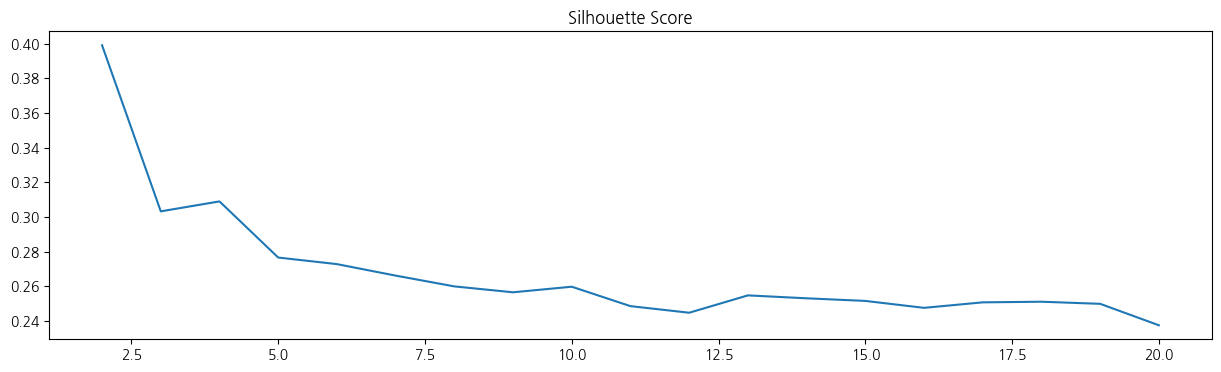

In [20]:
plt.figure(figsize=(15,4))
plt.title('Silhouette Score')
plt.plot(range_n_clusters,silhouettes)
plt.show()

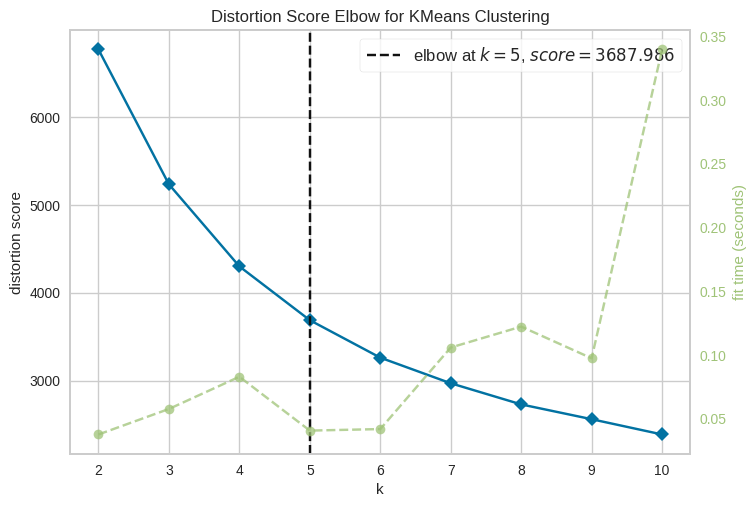

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
# 군집화 시각화를 위한 yellowbrick
from yellowbrick.cluster import KElbowVisualizer

KEV = KElbowVisualizer(kmeans,n_int='auto')
KEV.fit(X)
KEV.show()

분석한 내용을 바탕으로 kemans n_cluster 값을 정해 학습

In [23]:
n_clusters = 3
kmeans2 = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
kmeans2.fit(X2)

KMeans(n_clusters=3, n_init='auto', random_state=42)

In [24]:
kmeans2.labels_.shape

(4338,)

In [25]:
pd.Series(kmeans2.labels_).value_counts()

0    1840
1    1497
2    1001
Name: count, dtype: int64

In [26]:
silhouette_avg = silhouette_score(X2,labels=kmeans2.labels_)
silhouette_avg

0.3033153127872086

In [27]:
X2.shape

(4338, 3)

In [29]:
X2.shape, kmeans2.labels_.shape

((4338, 3), (4338,))

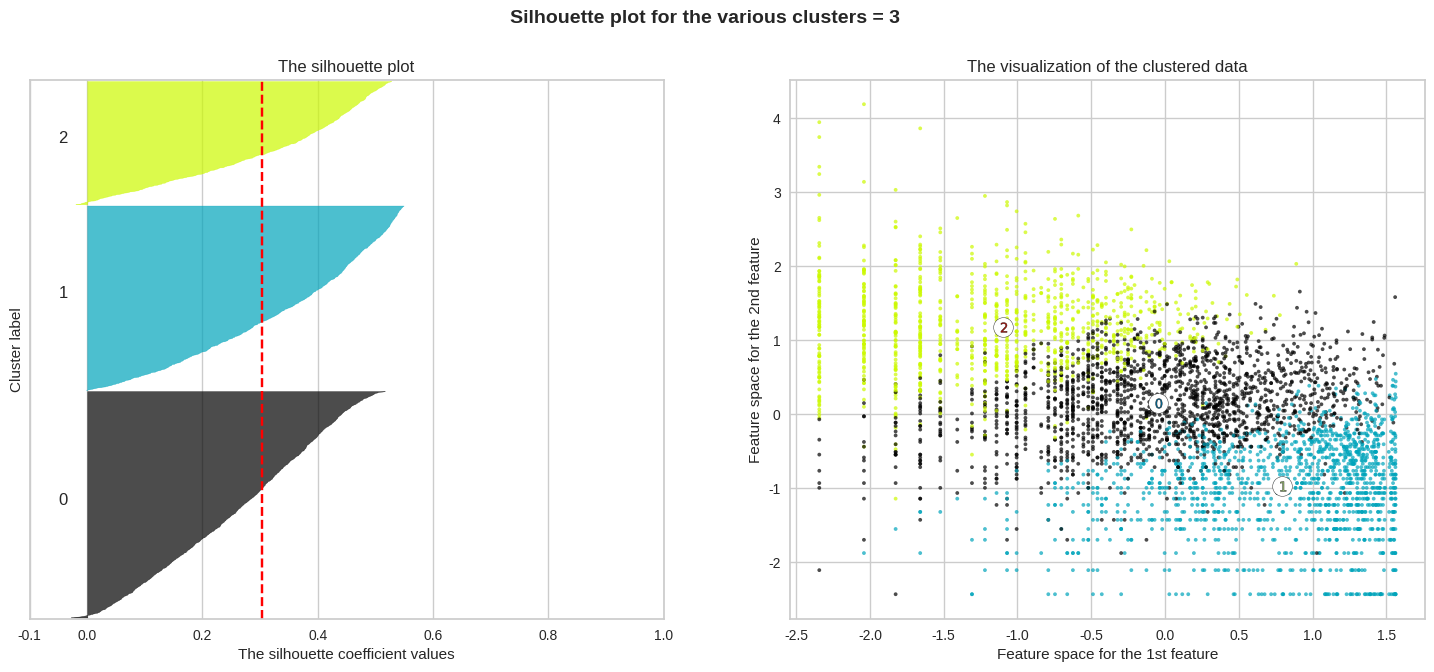

In [38]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X2) + (n_clusters + 1) * 10])

cluster_labels = kmeans2.labels_
sample_silhouette_values = silhouette_samples(X2, cluster_labels)
silhouette_avg = silhouette_score(X2, cluster_labels)

y_lower = 10

for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax1.set_title('The silhouette plot')
ax1.set_xlabel('The silhouette coefficient values')
ax1.set_ylabel('Cluster label')

ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X2.iloc[:, 0], X2.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

centers = kmeans2.cluster_centers_
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

ax2.set_title('The visualization of the clustered data')
ax2.set_xlabel('Feature space for the 1st feature')
ax2.set_ylabel('Feature space for the 2nd feature')

plt.suptitle(
    'Silhouette plot for the various clusters = %d' % n_clusters,
    fontsize=14,
    fontweight='bold'
)
plt.show()

In [39]:
rfm['Cluster'] = kmeans2.labels_

In [40]:
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
CustomerID,,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,silver,0
12347.0,2,182,4310.00,5,5,5,555,15,platinum,2
12348.0,75,31,1797.24,2,3,4,234,9,gold,0
12349.0,19,73,1757.55,4,4,4,444,12,platinum,0
12350.0,310,17,334.40,1,2,2,122,5,silver,1
...,...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,3,silver,1
18281.0,181,7,80.82,1,1,1,111,3,silver,1
18282.0,8,12,178.05,5,1,1,511,7,silver,0


**RFM_class와 군집결과 교차표**

In [41]:
pd.crosstab(rfm['RFM_class'],rfm['Cluster'])

Cluster,0,1,2
RFM_class,,,
gold,1375,15,19
platinum,279,0,982
silver,186,1482,0


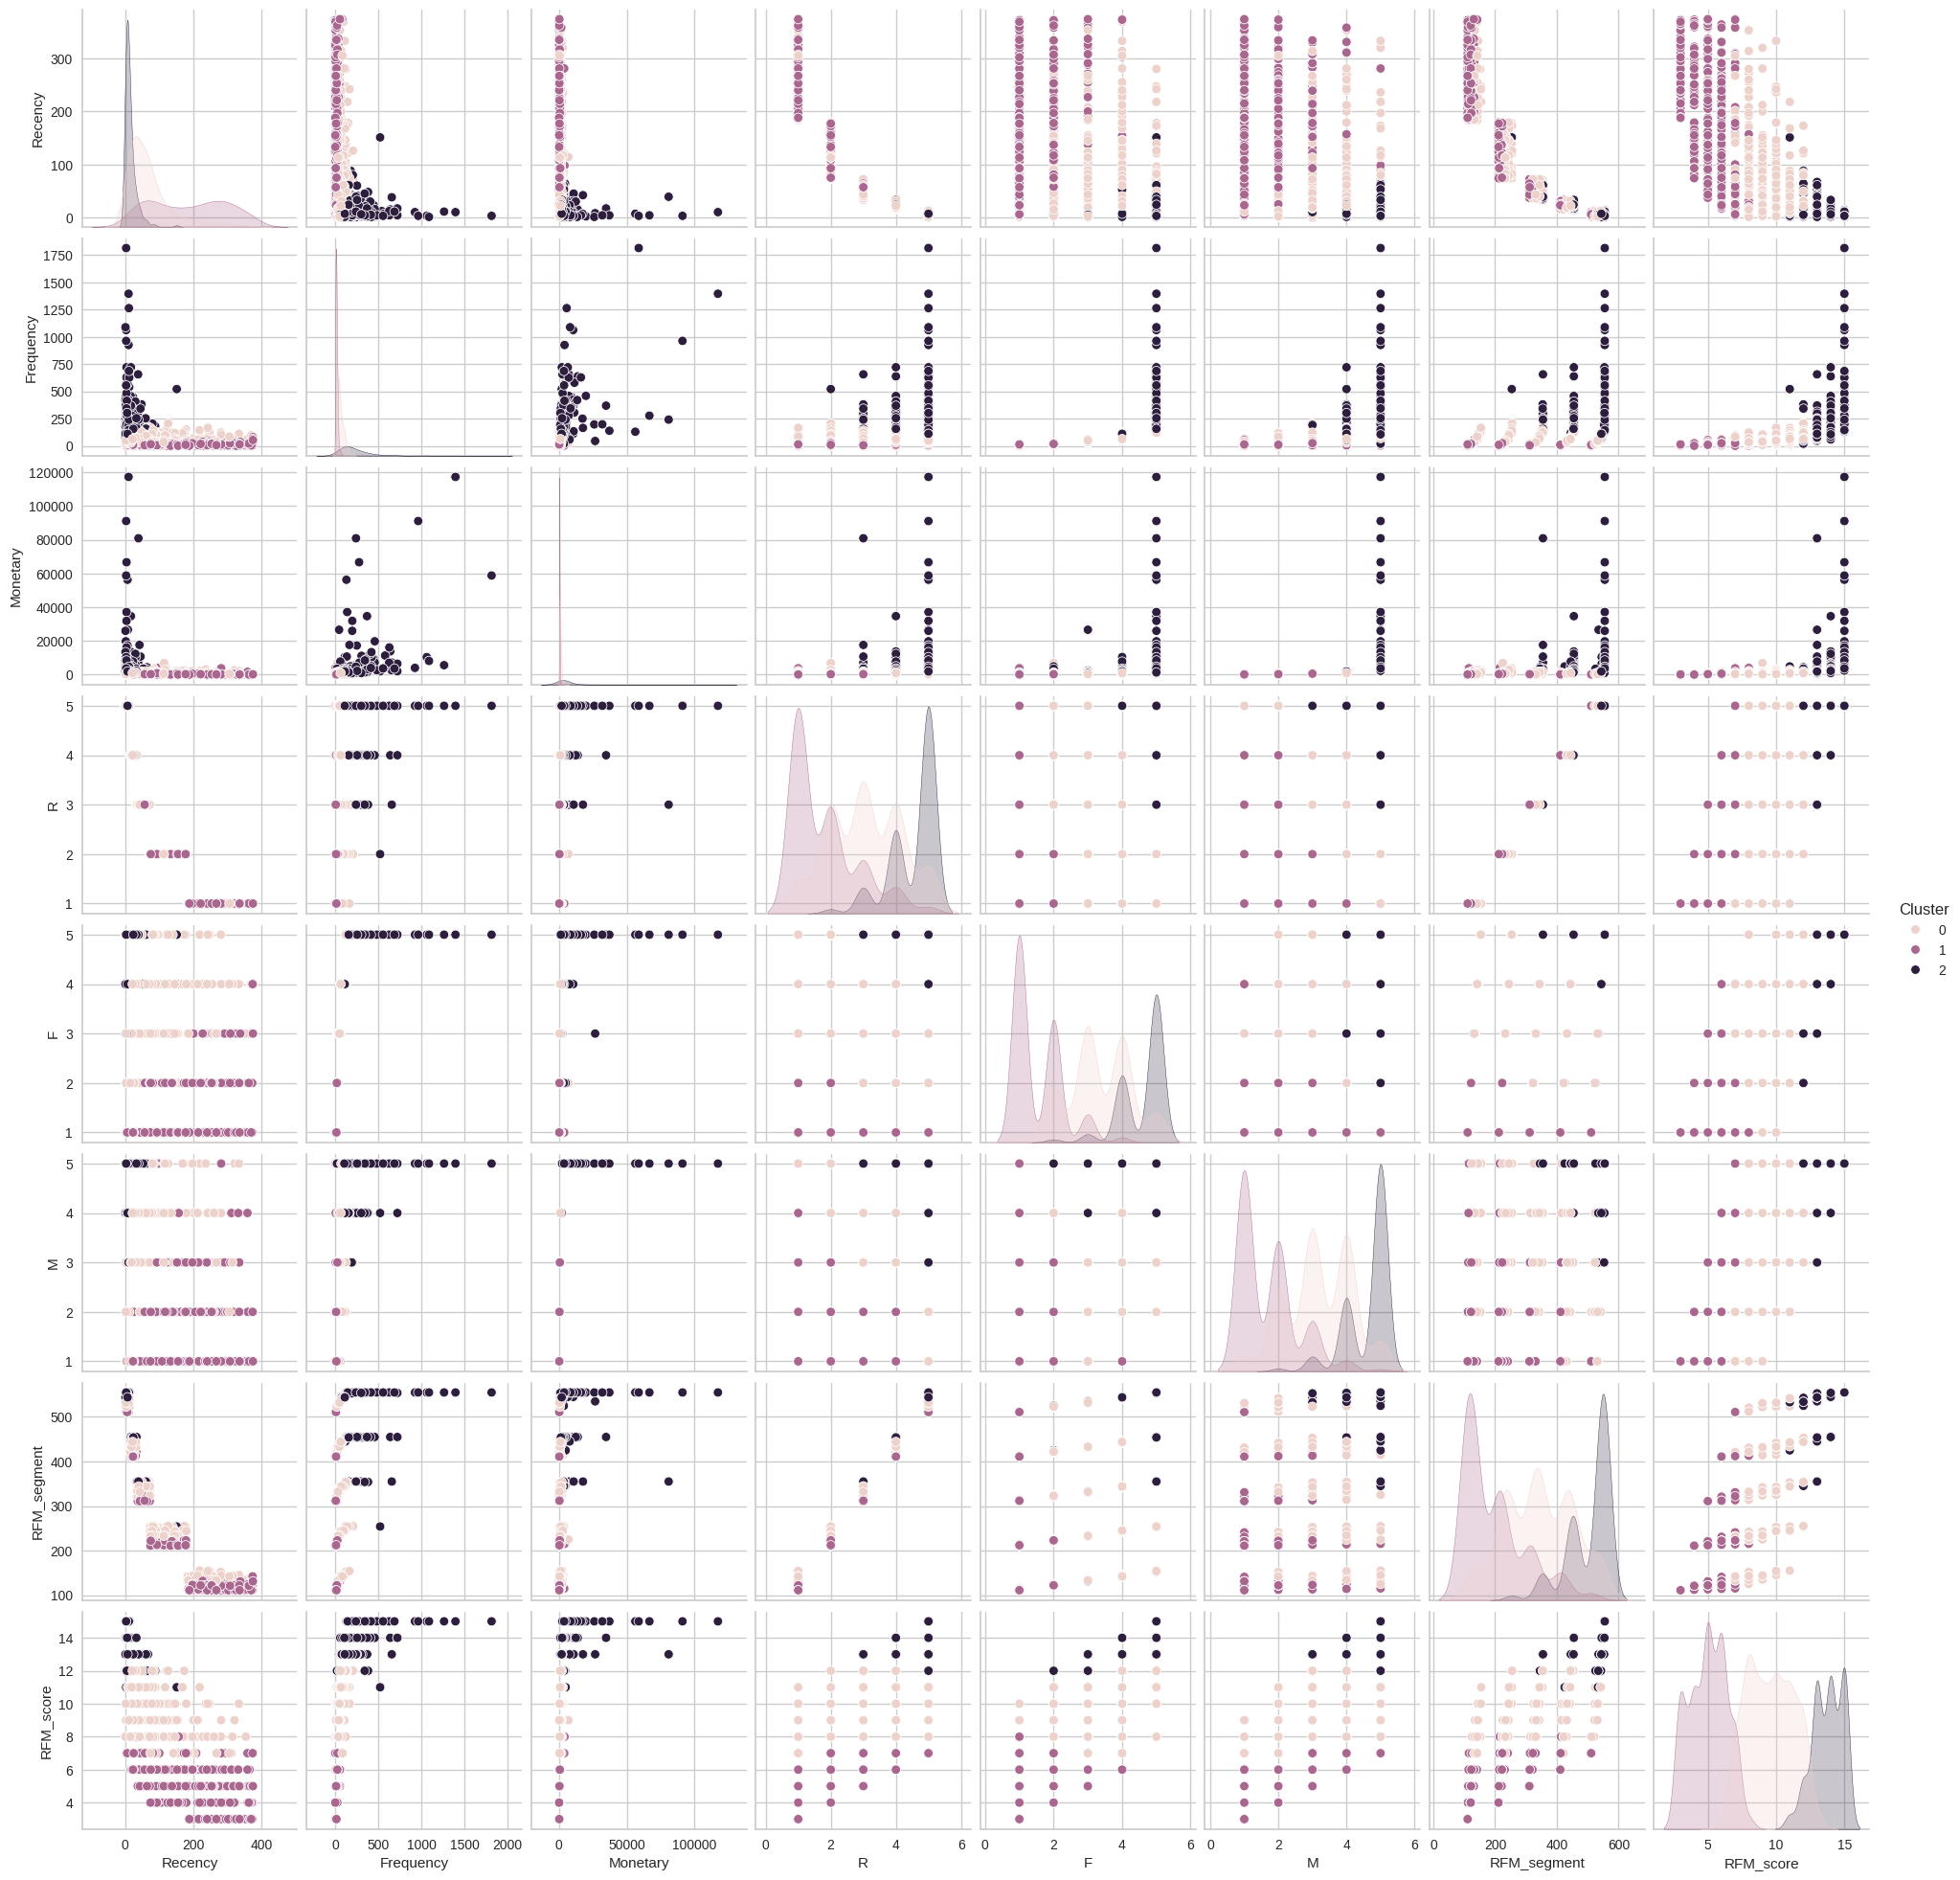

In [42]:
sns.pairplot(data=rfm.sample(1000),hue='Cluster')

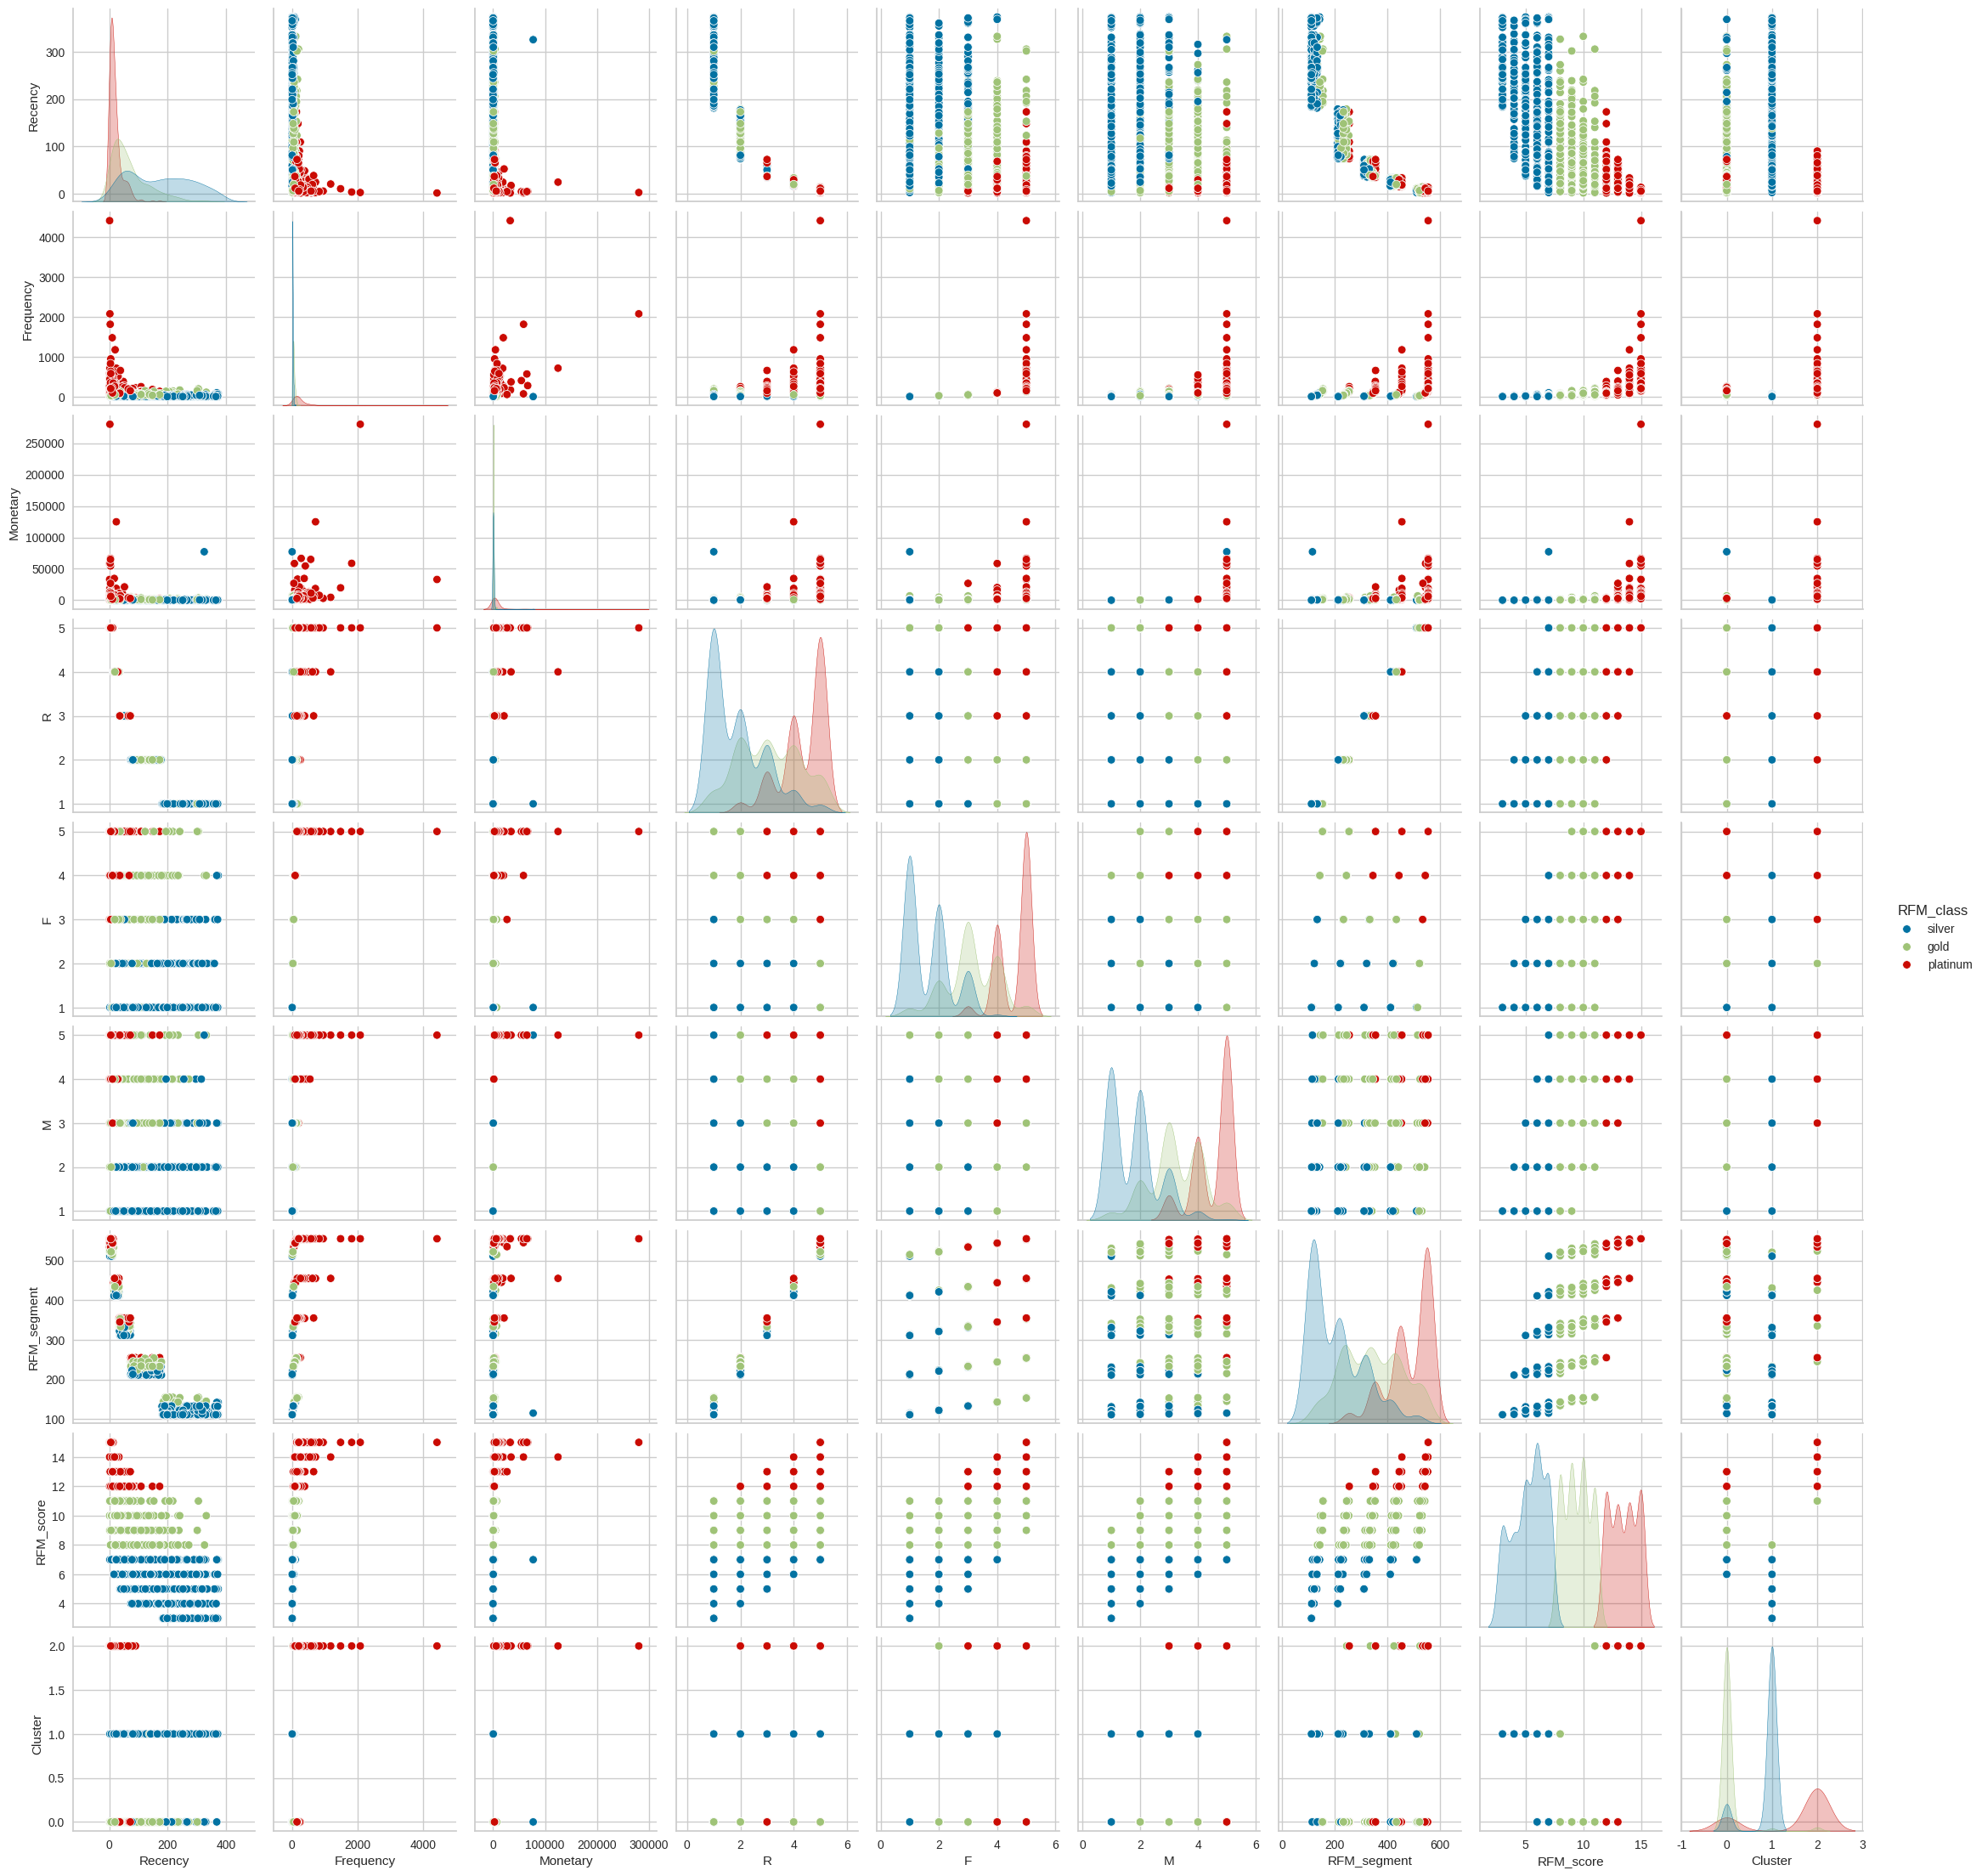

In [43]:
sns.pairplot(data=rfm.sample(1000),hue='RFM_class')